In [49]:
"""
Run regressions that strip predictable components of consumption and income
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home/mitch/school/data/mexico_enigh/src/')
sys.path.append('/home/mitch/util/python/')
from stargazer.stargazer import Stargazer

import mpl

import utils
import os

import statsmodels.stats.weightstats as ws

plotdir = '/home/mitch/school/data/mexico_enigh/fig/'

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed/'

save = False


In [50]:
os.chdir(processed)
df = pd.read_csv('data.csv')

df = df.query('Y >= 1996').query('Y <= 1998')
df['post'] = df['Y'] == 1998
df

/tmp/ipykernel_359442/4202296963.py:2: DtypeWarning: Columns (92,101,254,305,306,314,319,324) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,verifica,motivo,bustrab_1,bustrab_2,bustrab_3,bustrab_4,bustrab_5,bustrab_6,bustrab_7,post
23345,19960110010,1001,416.0,1,550.00,0.0,1056.55,0.0,1606.55,442.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23346,19960110020,1001,416.0,1,1565.00,0.0,1213.54,0.0,2778.54,2129.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23347,19960110030,1001,416.0,1,2250.00,500.0,2373.13,0.0,4623.13,3348.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23348,19960110040,1001,416.0,1,2850.00,500.0,987.83,0.0,3837.83,3016.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23349,19960110050,1001,416.0,1,275.00,0.0,1505.48,0.0,1780.48,232.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48334,19982640350,26057,1292.0,4,12996.52,4000.0,3154.32,0.0,16150.84,7330.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
48335,19982820280,28019,1575.0,4,4065.00,0.0,1021.07,0.0,5086.07,4772.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
48336,19982840130,28027,1460.0,1,23090.00,0.0,4369.40,0.0,27459.40,24231.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
48337,19982840140,28027,1460.0,1,22300.00,0.0,3178.03,0.0,25478.03,10404.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [51]:
cpidir = '/home/mitch/Dropbox/data/cpi/'
os.chdir(cpidir)
cpi = pd.read_csv('cpi_annual.csv')
cpi = cpi.rename(columns = {'time':'Y', 'PCPI_IX':'cpi'})
cpi = cpi.query('country == "MX"')
cpi = cpi.drop(columns=['Unnamed: 0', 'country'])

In [52]:
df = df.merge(cpi, on='Y', how='inner')

In [53]:
# don't include: other income
# transfers
# rental income

# do include:
# salary income
# business income

is1992 = df['Y'] == 1992

#income = ['salary_income', 'business_income', 'transfers_income']
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['income'] = df['income'] / df['cpi']
df['income'] = df['income'] / df['hh_size']
df.loc[is1992, 'income'] = df.loc[is1992, 'income'] / 1000
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
#consumption = ['consumption_food', 'consumption_clothing', 'consumption_personal', 'consumption_education']
df['consumption'] = df[consumption].sum(axis=1)
df['consumption'] = df['consumption'] / df['cpi']
df['consumption'] = df['consumption'] / df['hh_size']
df.loc[is1992, 'consumption'] = df.loc[is1992, 'consumption'] / 1000
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
df = df.query('relationship_to_hhm == 1')
df = df.query('income > 0')
df = df.query('consumption > 0')
df = df.query('age >= 25')
df = df.query('age <= 60')
df = df[df['location_size'].apply(lambda x : x not in [4.0, 5.0])]

In [55]:
consumption_to_income = ws.DescrStatsW(df['consumption'] / df['income'], weights=df['weight'])
consumption_to_income_005 = consumption_to_income.quantile(0.005)
consumption_to_income_995 = consumption_to_income.quantile(0.995)
df = df[df['consumption'] / df['income'] > consumption_to_income_005.values[0]]
df = df[df['consumption'] / df['income'] < consumption_to_income_995.values[0]]

In [56]:
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = utils.get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
    

In [57]:
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')
df

,hhid,location,weight,location_size,ingmon,permon,gasnom,eronom,income_current,gasmon,...,bustrab_5,bustrab_6,bustrab_7,post,cpi,income,log_income,consumption,log_consumption,decile
0,19960110020,1001,416.0,1,1565.0,0.0,1213.54,0.0,2778.54,2129.84,...,NaN,NaN,NaN,False,35.467989,11.031074,2.400716,9.605070,2.262291,1
1,19960110030,1001,416.0,1,2250.0,500.0,2373.13,0.0,4623.13,3348.84,...,NaN,NaN,NaN,False,35.467989,21.145828,3.051443,20.404220,3.015742,2
2,19960110060,1001,1488.0,1,3265.0,0.0,1483.85,0.0,4748.85,5270.97,...,NaN,NaN,NaN,False,35.467989,10.228315,2.325160,7.728785,2.044952,1
3,19960110070,1001,1488.0,1,51050.0,0.0,6259.55,0.0,57309.55,20178.74,...,NaN,NaN,NaN,False,35.467989,359.831510,5.885636,90.495686,4.505302,10
4,19960110080,1001,1488.0,1,2400.0,0.0,1862.80,0.0,4262.80,5281.13,...,NaN,NaN,NaN,False,35.467989,16.916663,2.828299,26.516798,3.277778,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12542,19982520150,25001,2567.0,1,31952.0,0.0,1226.68,0.0,33178.68,13208.32,...,NaN,NaN,NaN,True,49.598207,161.054209,5.081741,19.075034,2.948380,9
12543,19982540030,25006,2591.0,1,28650.0,500.0,5798.57,0.0,34448.57,17812.24,...,NaN,NaN,NaN,True,49.598207,192.547283,5.260342,60.232419,4.098211,10
12544,19982840130,28027,1460.0,1,23090.0,0.0,4369.40,0.0,27459.40,24231.46,...,NaN,NaN,NaN,True,49.598207,77.590170,4.351441,60.452992,4.101866,7
12545,19982840140,28027,1460.0,1,22300.0,0.0,3178.03,0.0,25478.03,10404.98,...,NaN,NaN,NaN,True,49.598207,89.922605,4.498949,28.564581,3.352168,8


In [58]:
params = ['post[T.True]:C(decile)[' + str(x) + ']' for x in np.arange(1, 11) ]

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws

from statsmodels.genmod.families.links import identity
fam = sm.families.Gaussian(identity())

In [60]:
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = ' post:C(education) + post:C(sex)'

income_reg = 'log_income ~ ' + Z + '+' + D
#income_reg = 'log_income ~ ' + Z 
#income_model = smf.wls(income_reg, df, weights=df['weight']).fit()
income_model = smf.glm(income_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_income_resid'] = income_model.resid

In [61]:
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
#Z = 'age + I(age**2) + C(sex) + C(education) + C(hh_size)  + C(location_size)'
Z = 'age + I(age**2) + C(sex) + C(education) + C(location_size) + C(decile)'
D = 'post:C(decile) + post:C(education) + post:C(sex)'
#D = 'post:C(education) + post:C(sex)'

consumption_reg = 'log_consumption ~ ' + Z + '+' + D
#income_reg = 'log_consumption ~ ' + Z 
#consumption_model = smf.wls(consumption_reg, df, weights=df['weight']).fit()
consumption_model = smf.glm(consumption_reg, df, freq_weights=df['weight'], missing='drop', family=fam).fit()
#df['log_consumption_resid'] = consumption_model.resid

In [62]:
consumption_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        log_consumption   No. Observations:                12547
Model:                            GLM   Df Residuals:                 24958490
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                         0.22280
Method:                          IRLS   Log-Likelihood:            -1.6677e+07
Date:                Fri, 17 Nov 2023   Deviance:                   5.5608e+06
Time:                        23:36:46   Pearson chi2:                 5.56e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.3597      0.002   1227.172      0.000       2.356       2.363
C(sex)[T.2]                             0.0444      0.000    116.483      0.000       0.044       0.045
C(education)[T.low]                    -0.0117      0.000    -24.629      0.000      -0.013      -0.011
C(education)[T.medium]                  0.0217      0.000     48.605      0.000       0.021       0.023
C(location_size)[T.2]                   0.0179      0.000     68.334      0.000       0.017       0.018
C(location_size)[T.3]                  -0.0082      0.000    -29.750      0.000      -0.009      -0.008
C(decile)[T.2]                          0.3954      0.001    647.602      0.000       0.394       0.397
C(decile)[T.3]                          0.6036      0.001    974.769      0.000       0.602       0.605
C(decile)[T.4]                          0.7677      0.001   1251.978      0.000       0.766       0.769
C(decile)[T.5]                          0.9016      0.001   1455.986      0.000       0.900       0.903
C(decile)[T.6]                          1.0310      0.001   1654.766      0.000       1.030       1.032
C(decile)[T.7]                          1.2330      0.001   1970.432      0.000       1.232       1.234
C(decile)[T.8]                          1.4248      0.001   2230.822      0.000       1.424       1.426
C(decile)[T.9]                          1.6566      0.001   2514.745      0.000       1.655       1.658
C(decile)[T.10]                         2.1777      0.001   3137.757      0.000       2.176       2.179
post[T.True]:C(decile)[1]               0.1411      0.001    164.856      0.000       0.139       0.143
post[T.True]:C(decile)[2]               0.1836      0.001    217.667      0.000       0.182       0.185
post[T.True]:C(decile)[3]               0.1736      0.001    206.573      0.000       0.172       0.175
post[T.True]:C(decile)[4]               0.1366      0.001    165.571      0.000       0.135       0.138
post[T.True]:C(decile)[5]               0.1257      0.001    153.157      0.000       0.124       0.127
post[T.True]:C(decile)[6]               0.1289      0.001    158.470      0.000       0.127       0.131
post[T.True]:C(decile)[7]               0.1242      0.001    159.079      0.000       0.123       0.126
post[T.True]:C(decile)[8]               0.1042      0.001    138.436      0.000       0.103       0.106
post[T.True]:C(decile)[9]               0.0547      0.001     78.805      0.000       0.053       0.056
post[T.True]:C(decile)[10]              0.0538      0.001     84.029      0.000       0.053       0.055
post[T.True]:C(education)[T.low]       -0.0561      0.001    -86.026      0.000      -0.057      -0.055
post[T.True]:C(education)[T.medium]    -0.0519      0.001    -83.66

In [63]:
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             log_income   No. Observations:                12547
Model:                            GLM   Df Residuals:                 24958490
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                        0.047242
Method:                          IRLS   Log-Likelihood:             2.6779e+06
Date:                Fri, 17 Nov 2023   Deviance:                   1.1791e+06
Time:                        23:36:46   Pearson chi2:                 1.18e+06
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.4860      0.001   2807.634      0.000       2.484       2.488
C(sex)[T.2]                            -0.0066      0.000    -37.520      0.000      -0.007      -0.006
C(education)[T.low]                    -0.0586      0.000   -267.258      0.000      -0.059      -0.058
C(education)[T.medium]                 -0.0558      0.000   -270.794      0.000      -0.056      -0.055
C(location_size)[T.2]                  -0.0098      0.000    -81.237      0.000      -0.010      -0.010
C(location_size)[T.3]                  -0.0540      0.000   -426.159      0.000      -0.054      -0.054
C(decile)[T.2]                          0.5573      0.000   1981.916      0.000       0.557       0.558
C(decile)[T.3]                          0.8432      0.000   2957.415      0.000       0.843       0.844
C(decile)[T.4]                          1.0663      0.000   3776.416      0.000       1.066       1.067
C(decile)[T.5]                          1.2782      0.000   4482.723      0.000       1.278       1.279
C(decile)[T.6]                          1.4889      0.000   5189.952      0.000       1.488       1.490
C(decile)[T.7]                          1.7147      0.000   5950.812      0.000       1.714       1.715
C(decile)[T.8]                          1.9765      0.000   6720.781      0.000       1.976       1.977
C(decile)[T.9]                          2.3698      0.000   7812.078      0.000       2.369       2.370
C(decile)[T.10]                         3.1523      0.000   9863.853      0.000       3.152       3.153
post[T.True]:C(decile)[1]               0.0845      0.000    214.509      0.000       0.084       0.085
post[T.True]:C(decile)[2]               0.1569      0.000    403.831      0.000       0.156       0.158
post[T.True]:C(decile)[3]               0.1463      0.000    378.251      0.000       0.146       0.147
post[T.True]:C(decile)[4]               0.1459      0.000    384.041      0.000       0.145       0.147
post[T.True]:C(decile)[5]               0.1442      0.000    381.575      0.000       0.143       0.145
post[T.True]:C(decile)[6]               0.1521      0.000    405.945      0.000       0.151       0.153
post[T.True]:C(decile)[7]               0.1555      0.000    432.327      0.000       0.155       0.156
post[T.True]:C(decile)[8]               0.1713      0.000    494.460      0.000       0.171       0.172
post[T.True]:C(decile)[9]               0.1238      0.000    386.857      0.000       0.123       0.124
post[T.True]:C(decile)[10]              0.1386      0.000    469.957      0.000       0.138       0.139
post[T.True]:C(education)[T.low]       -0.0089      0.000    -29.527      0.000      -0.009      -0.008
post[T.True]:C(education)[T.medium]     0.0040      0.000     13.87

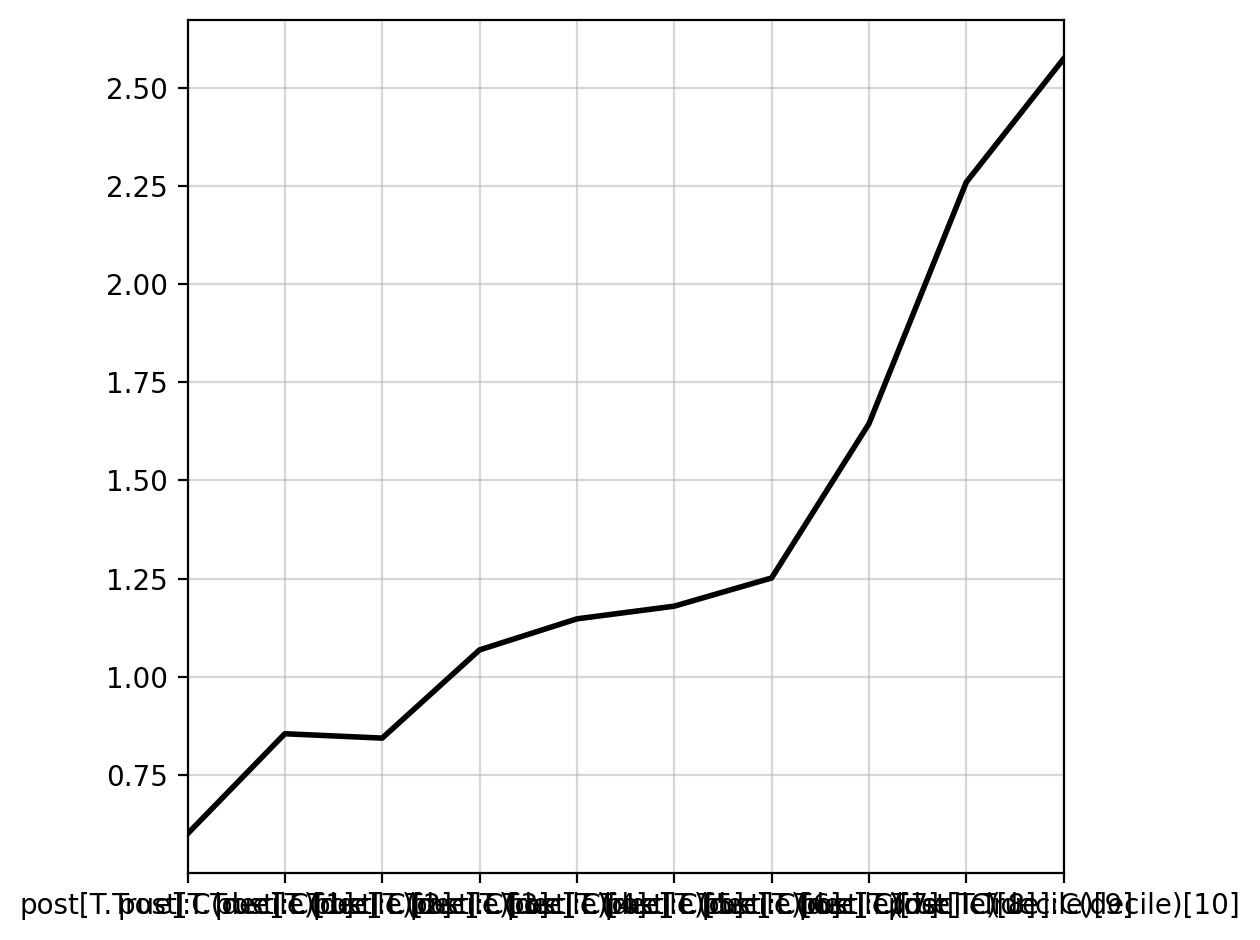

In [64]:
plt.clf()
plt.plot(income_model.params[params] / consumption_model.params[params])
plt.show()

In [70]:
nboot = 2000
dconsumption = np.zeros((nboot, 10))
dincome = np.zeros((nboot, 10))
for boot in np.arange(nboot):
    # matters alot: double vs single resampling of the data
    # something tells me single sampling is correct
    # this is correct because: are matching the samples of the original data 
    # so should be all set 
    data_boot = df.copy().sample(len(data), weights=df['weight'], replace=True, axis=0)
    #data_boot = df.copy().sample(len(data), replace=True, axis=0)

    #consumption_model = smf.wls(consumption_reg, data_boot, weights=data_boot['weight']).fit()
    #consumption_model = smf.glm(consumption_reg, data_boot, freq_weights=data_boot['weight'], missing='drop', family=fam).fit()
    consumption_model = smf.glm(consumption_reg, data_boot, missing='drop', family=fam).fit()
    dconsumption[boot, :] = consumption_model.params[params]

    #income_model = smf.wls(income_reg, data_boot, weights=data_boot['weight']).fit()
    #income_model = smf.glm(income_reg, data_boot, freq_weights=data_boot['weight'],  missing='drop', family=fam).fit()
    income_model = smf.glm(income_reg, data_boot,  missing='drop', family=fam).fit()
    dincome[boot, :] = income_model.params[params]


In [71]:
dincome

array([[0.12526916, 0.16669467, 0.15628509, ..., 0.19154179, 0.11421223,
        0.18102639],
       [0.18570186, 0.18239609, 0.2018263 , ..., 0.19546724, 0.16082892,
        0.17813574],
       [0.09549196, 0.16894298, 0.16737405, ..., 0.18854847, 0.13414597,
        0.20926646],
       ...,
       [0.14645442, 0.16449379, 0.14827069, ..., 0.17308142, 0.10475704,
        0.14345859],
       [0.15622091, 0.18944149, 0.18590976, ..., 0.21726899, 0.13199999,
        0.14774635],
       [0.04120989, 0.13223495, 0.11213068, ..., 0.15545544, 0.1298369 ,
        0.06778271]])

In [72]:
deciles = np.arange(1, 11)

dconsumption_c10 = [np.quantile(dconsumption[:, ii], 0.10) for ii in np.arange(10)]
dconsumption_c90 = [np.quantile(dconsumption[:, ii], 0.90) for ii in np.arange(10)]
dconsumption_mean = [np.mean(dconsumption[:, ii]) for ii in np.arange(10)]

dincome_c10 = [np.quantile(dincome[:, ii], 0.10) for ii in np.arange(10)]
dincome_c90 = [np.quantile(dincome[:, ii], 0.90) for ii in np.arange(10)]
dincome_mean = [np.mean(dincome[:, ii]) for ii in np.arange(10)]


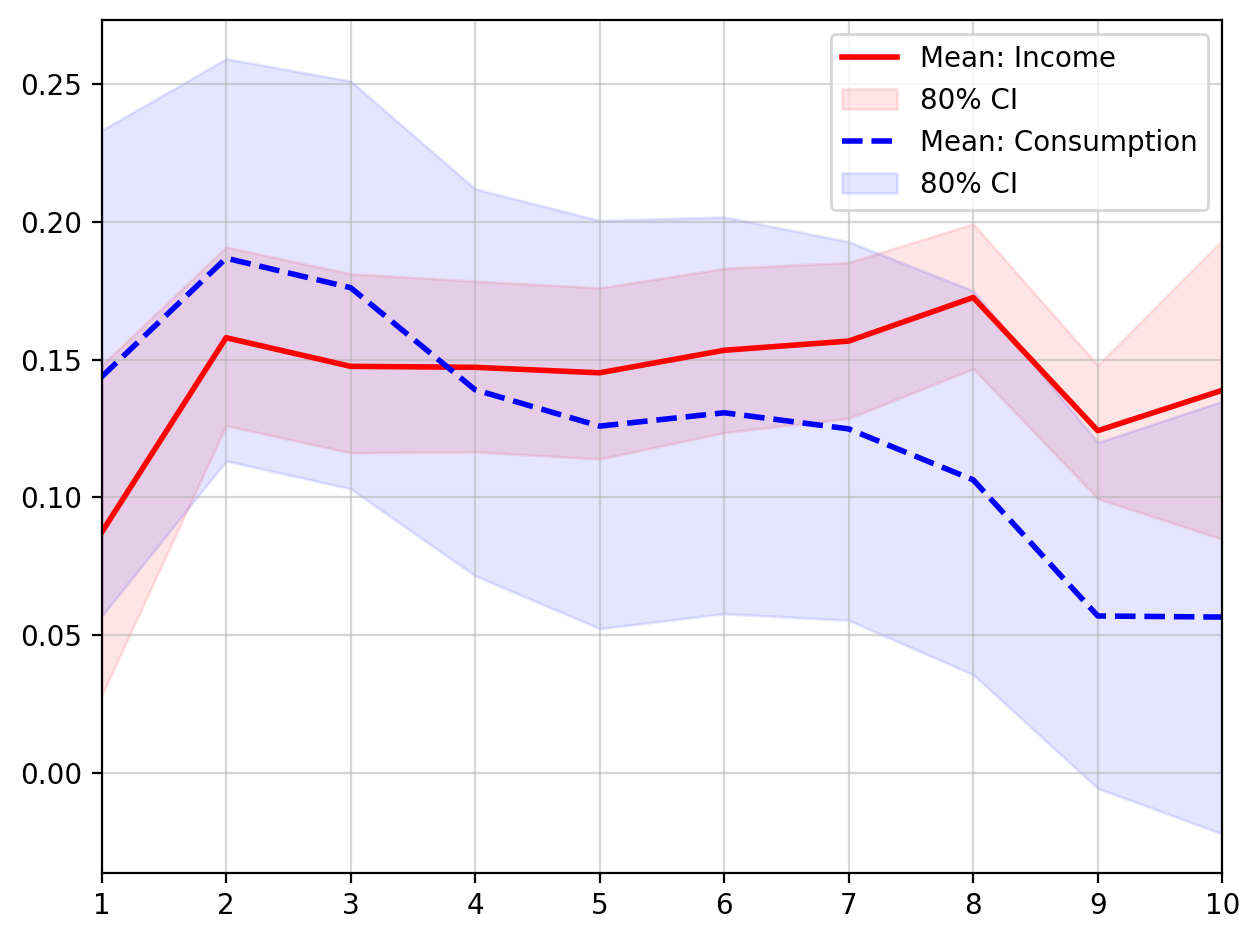

In [73]:
plt.clf()

plt.plot(deciles, dincome_mean, color='red', label='Mean: Income')
plt.fill_between(deciles, dincome_c10, dincome_c90, color='red', alpha=0.10, label='80% CI')

plt.plot(deciles, dconsumption_mean, color='blue', label='Mean: Consumption')
plt.fill_between(deciles, dconsumption_c10, dconsumption_c90, color='blue', alpha=0.10, label='80% CI')

plt.legend()


#plt.gca().set_ylim(top=0)
plt.show()
#plt.plot(dconsumption_c10, label='lower')
#plt.plot(dconsumption_c90, label='upper')

<Figure size 1280x960 with 0 Axes>

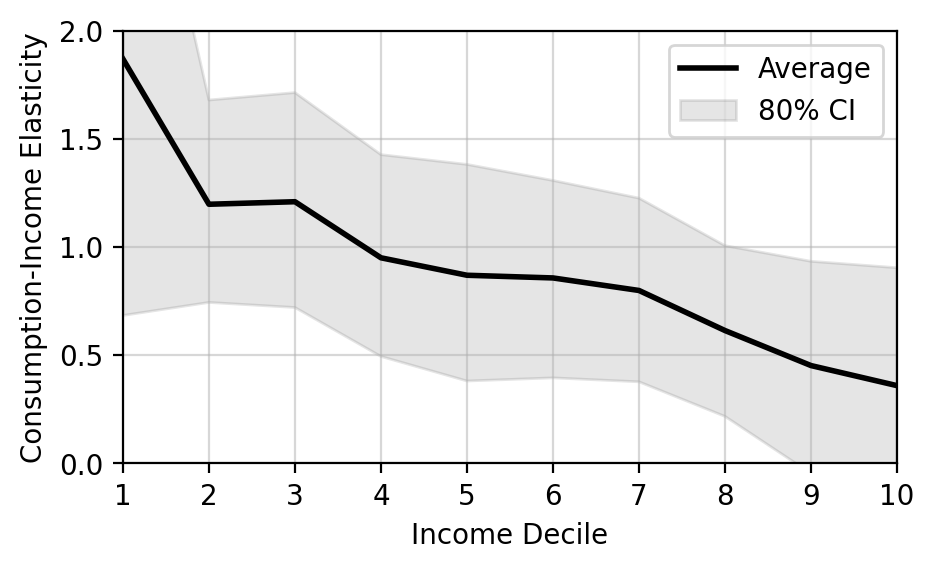

In [75]:
delasticity = dconsumption / dincome

plt.clf()
plt.figure(figsize = mpl.set_size())

delasticity_c10 = [np.quantile(delasticity[:, ii], 0.10) for ii in np.arange(10)]
delasticity_c90 = [np.quantile(delasticity[:, ii], 0.90) for ii in np.arange(10)]
delasticity_mean = [np.mean(delasticity[:, ii]) for ii in np.arange(10)]

plt.plot(deciles, delasticity_mean, label='Average', color='black')
plt.fill_between(deciles, delasticity_c10, delasticity_c90, color='black', alpha=0.10, label='80% CI')
plt.xlabel('Income Decile')
plt.ylim(0, 2.0)
plt.yticks(np.arange(0, 2.50, 0.50))
plt.ylabel('Consumption-Income Elasticity')

plt.legend()

if save:
    os.chdir(plotdir)
#    plt.savefig('elasticity_1994_1996_cugat_withci.png')
plt.show()
    

#plt.gca().set_ylim(top=0)